In [1]:
import os
import word2vec
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

/home/chris/.pyenv/versions/3.7.5/envs/work/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


## Download toy corpus for wordvector training and example text

In [2]:
corpus_path = './text8'  # be sure your corpus is cleaned from punctuation and lowercased
if not os.path.exists(corpus_path):
    !wget http://mattmahoney.net/dc/text8.zip
    !unzip {corpus_path}

links = {'tale2cities': 'https://www.gutenberg.org/files/98/98-0.txt',  # a tale of two cities
         'siddartha': 'http://www.gutenberg.org/cache/epub/2500/pg2500.txt'}  # siddartha

for link in links.values():
    text_path = os.path.basename(link)
    if not os.path.exists(text_path):
        !wget {link}

## Train wordvectors

In [3]:
wrdvec_path = 'wrdvecs.bin'
if not os.path.exists(wrdvec_path):
    %time word2vec.word2vec(corpus_path, wrdvec_path, cbow=1, iter_=5, hs=1, threads=8, sample='1e-5', window=15, size=200, binary=1)

In [4]:
model = word2vec.load(wrdvec_path)
wrdvecs = pd.DataFrame(model.vectors, index=model.vocab)
del model
print(wrdvecs.shape)

(71291, 200)


## get sentence tokenizer

In [5]:
from textsplit.tools import SimpleSentenceTokenizer
sentence_tokenizer = SimpleSentenceTokenizer()

## run get_penalty and split_optimal

In [6]:
%matplotlib inline
from textsplit.tools import get_penalty, get_segments
from textsplit.algorithm import split_optimal, split_greedy, get_total

penalty 3.02
8591 sentences, 391 segments, avg 21.97 sentences per segment
optimal score 51703.94, greedy score 51615.21
ratio of scores 1.0017


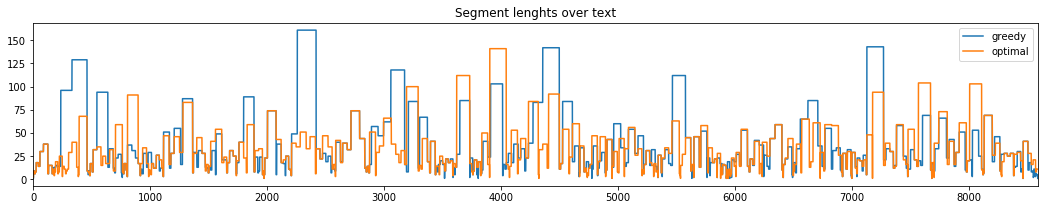

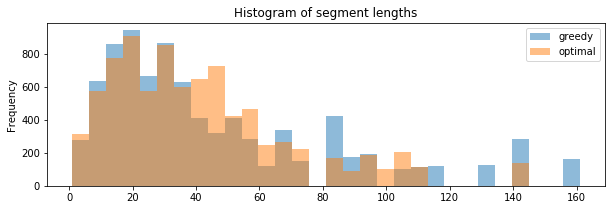

In [7]:
# link = links['siddartha']
link = links['tale2cities']
segment_len = 30  # segment target length in sentences
book_path = os.path.basename(link)

with open(book_path, 'rt') as f:
    text = f.read()  #.replace('\n', ' ')  # punkt tokenizer handles newlines not so nice

sentenced_text = sentence_tokenizer(text)
vecr = CountVectorizer(vocabulary=wrdvecs.index)

sentence_vectors = vecr.transform(sentenced_text).dot(wrdvecs)

penalty = get_penalty([sentence_vectors], segment_len)
print('penalty %4.2f' % penalty)

optimal_segmentation = split_optimal(sentence_vectors, penalty, seg_limit=250)
segmented_text = get_segments(sentenced_text, optimal_segmentation)

print('%d sentences, %d segments, avg %4.2f sentences per segment' % (
    len(sentenced_text), len(segmented_text), len(sentenced_text) / len(segmented_text)))

with open(book_path + '.seg', 'wt') as f:
    for i, segment_sentences in enumerate(segmented_text):
        segment_str = ' // '.join(segment_sentences)
        gain = optimal_segmentation.gains[i] if i < len(segmented_text) - 1 else 0
        segment_info = ' [%d sentences, %4.3f] ' % (len(segment_sentences), gain) 
        print(segment_str + '\n8<' + '=' * 30 + segment_info + "=" * 30, file=f)

greedy_segmentation = split_greedy(sentence_vectors, max_splits=len(optimal_segmentation.splits))
greedy_segmented_text = get_segments(sentenced_text, greedy_segmentation)
lengths_optimal = [len(segment) for segment in segmented_text for sentence in segment]
lengths_greedy = [len(segment) for segment in greedy_segmented_text for sentence in segment]
df = pd.DataFrame({'greedy':lengths_greedy, 'optimal': lengths_optimal})
df.plot.line(figsize=(18, 3), title='Segment lenghts over text')
df.plot.hist(bins=30, alpha=0.5, figsize=(10, 3), title='Histogram of segment lengths')

totals = [get_total(sentence_vectors, seg.splits, penalty) 
          for seg in [optimal_segmentation, greedy_segmentation]]
print('optimal score %4.2f, greedy score %4.2f' % tuple(totals))
print('ratio of scores %5.4f' % (totals[0] / totals[1]))

## Evaluation

If you look into the written file `book_path`.seg, the snippet line is often at the boundary of a paragraph.  The word embeddings computed above are neither very good nor adapted to the text. Every unknown word has a zero vector. Choosing some more or less random vector for unknown words might improve the accuracy given those unknown terms appear repeatedly within a section.